In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if False:
    import os
    # Turn off GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    gpu = False
else:
    gpu = True

from tensorflow import keras
from copy import deepcopy
import tensorflow as tf
from glob import glob
import numpy as np
import os

gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

if gpu:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024 * 4))])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from glob import glob

modelsFolder = np.array(sorted(glob("model-saved\\deeplabV3+_mobileNetV2\\*")))

index_model_0_5 = np.char.find(modelsFolder, "_alpha_0.5") != -1

models_0_5 = modelsFolder[index_model_0_5]
models_1_0 = modelsFolder[~index_model_0_5]

models_0_5, models_1_0

(array(['model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_0.5_lr_0.0001_regularizer_l1_0.0001_l2_1e-05',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_0.5_lr_0.0001_regularizer_l1_1e-05_l2_1e-05',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_0.5_lr_0.0001_regularizer_l1_1e-05_l2_1e-06',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_0.5_lr_0.001_regularizer_l1_0.0001_l2_1e-05',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_0.5_lr_0.001_regularizer_l1_0.0001_l2_1e-06',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_0.5_lr_0.001_regularizer_l1_1e-05_l2_1e-05'],
       dtype='<U98'),
 array(['model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_1.0_lr_0.0001_regularizer_l1_0.0001_l2_1e-05',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_1.0_lr_0.0001_regularizer_l1_0.0001_l2_1e-06',
        'model-saved\\deeplabV3+_mobileNetV2\\deeplayer_12_alpha_1.0_lr_0.0001_regulari

In [ ]:
import pandas as pd

class Metrics():
    def __init__(self, modelsPath):
        self.modelsPath = modelsPath
    
    def __getAllMetrics(self, folds=3):
        modelsDictDF = {}

        for model in self.modelsPath:
            modelName = model.replace("/", "\\").split("\\")[-1]
            modelsDictDF[modelName] = {}

            for i in range(folds):
                modelsDictDF[modelName][f"fold_{i}"] = pd.read_csv(f"{model}/fold_{i}.csv")

        return modelsDictDF

    def __getMinFromMetrics(self, modelsDictDF, metric="val_loss"):
        minPerFold = {}

        for key in modelsDictDF.keys():
            minPerFold[key] = {}
            valuesNP = []

            for key_key in modelsDictDF[key].keys():
                value = modelsDictDF[key][key_key][metric].min()

                minPerFold[key][key_key] = value
                valuesNP.append(value)

            valuesNP = np.array(valuesNP)
            minPerFold[key]["mean"] = valuesNP.mean()
            minPerFold[key]["std"] = valuesNP.std()


        return minPerFold
    
    def get(self, folds=3, metric="val_loss"):
        return  self.__getMinFromMetrics(self.__getAllMetrics(folds=folds), metric="val_loss")
    
    def show(self, folds=3, metric="val_loss", round=4):
        for key, values in self.get(folds=folds, metric=metric).items():
            print(key)
            for _key, _values in values.items():
                print(f"{_key}: {np.round(_values, round)}")

In [59]:
Metrics(models_0_5).show(folds=3, metric="val_loss")

deeplayer_12_alpha_0.5_lr_0.0001_regularizer_l1_0.0001_l2_1e-05
fold_0: 0.2419
fold_1: 0.2419
fold_2: 0.2411
mean: 0.2416
std: 0.0004
deeplayer_12_alpha_0.5_lr_0.0001_regularizer_l1_1e-05_l2_1e-05
fold_0: 0.2412
fold_1: 0.2415
fold_2: 0.2401
mean: 0.241
std: 0.0006
deeplayer_12_alpha_0.5_lr_0.0001_regularizer_l1_1e-05_l2_1e-06
fold_0: 0.2412
fold_1: 0.2415
fold_2: 0.2401
mean: 0.2409
std: 0.0006
deeplayer_12_alpha_0.5_lr_0.001_regularizer_l1_0.0001_l2_1e-05
fold_0: 0.2411
fold_1: 0.2406
fold_2: 0.2396
mean: 0.2404
std: 0.0006
deeplayer_12_alpha_0.5_lr_0.001_regularizer_l1_0.0001_l2_1e-06
fold_0: 0.2408
fold_1: 0.2406
fold_2: 0.2396
mean: 0.2403
std: 0.0006
deeplayer_12_alpha_0.5_lr_0.001_regularizer_l1_1e-05_l2_1e-05
fold_0: 0.2402
fold_1: 0.2403
fold_2: 0.239
mean: 0.2399
std: 0.0006


In [60]:
Metrics(models_1_0).show(folds=3, metric="val_loss")

deeplayer_12_alpha_1.0_lr_0.0001_regularizer_l1_0.0001_l2_1e-05
fold_0: 0.2412
fold_1: 0.2411
fold_2: 0.2401
mean: 0.2408
std: 0.0005
deeplayer_12_alpha_1.0_lr_0.0001_regularizer_l1_0.0001_l2_1e-06
fold_0: 0.2412
fold_1: 0.2412
fold_2: 0.24
mean: 0.2408
std: 0.0005
deeplayer_12_alpha_1.0_lr_0.0001_regularizer_l1_1e-05_l2_1e-05
fold_0: 0.2407
fold_1: 0.2407
fold_2: 0.2394
mean: 0.2403
std: 0.0006
deeplayer_12_alpha_1.0_lr_0.0001_regularizer_l1_1e-05_l2_1e-06
fold_0: 0.2407
fold_1: 0.2407
fold_2: 0.2395
mean: 0.2403
std: 0.0006
deeplayer_12_alpha_1.0_lr_0.001_regularizer_l1_0.0001_l2_1e-05
fold_0: 0.2398
fold_1: 0.2398
fold_2: 0.2386
mean: 0.2394
std: 0.0006
deeplayer_12_alpha_1.0_lr_0.001_regularizer_l1_1e-05_l2_1e-06
fold_0: 0.2394
fold_1: 0.2393
fold_2: 0.2382
mean: 0.239
std: 0.0005


In [3]:
from utils import data_utils
from glob import glob

DATA_DIR = "utils/split/_split_/_type_"
IMG_SIZE = (256, 256)
train_X = sorted(glob(DATA_DIR.replace("_split_", "TrainVal").replace("_type_", "img") + "\\*"))
train_Y = sorted(glob(DATA_DIR.replace("_split_", "TrainVal").replace("_type_", "mask") + "\\*"))

train_X += sorted(glob(DATA_DIR.replace("_split_", "TrainVal").replace("_type_", "imgFog") + "\\*"))
train_Y += sorted(glob(DATA_DIR.replace("_split_", "TrainVal").replace("_type_", "mask") + "\\*"))

# Train image has 1/3 chance to be flipped
# Train image has 1/3 chance to be cropped
trainDataset = data_utils.load_dataset(
    train_X, train_Y, BATCH_SIZE=32, IMAGE_SIZE=IMG_SIZE, REMAP="binary", CROP=True, flip=True)

test_X = sorted(glob(DATA_DIR.replace("_split_", "test").replace("_type_", "img") + "\\*"))
test_Y = sorted(glob(DATA_DIR.replace("_split_", "test").replace("_type_", "mask") + "\\*"))


test_data = data_utils.load_testset(test_X, test_Y, IMAGE_SIZE=IMG_SIZE, BATCH_SIZE=1, REMAP="binary")

In [4]:
np.unique(trainDataset.__getitem__(0)[0])

array([-0.94509804, -0.9372549 , -0.92941177, -0.92156863, -0.9137255 ,
       -0.90588236, -0.8980392 , -0.8901961 , -0.88235295, -0.8745098 ,
       -0.8666667 , -0.85882354, -0.8509804 , -0.84313726, -0.8352941 ,
       -0.827451  , -0.81960785, -0.8117647 , -0.8039216 , -0.79607844,
       -0.7882353 , -0.78039217, -0.77254903, -0.7647059 , -0.75686276,
       -0.7490196 , -0.7411765 , -0.73333335, -0.7254902 , -0.7176471 ,
       -0.70980394, -0.7019608 , -0.69411767, -0.6862745 , -0.6784314 ,
       -0.67058825, -0.6627451 , -0.654902  , -0.64705884, -0.6392157 ,
       -0.6313726 , -0.62352943, -0.6156863 , -0.60784316, -0.6       ,
       -0.5921569 , -0.58431375, -0.5764706 , -0.5686275 , -0.56078434,
       -0.5529412 , -0.54509807, -0.5372549 , -0.5294118 , -0.52156866,
       -0.5137255 , -0.5058824 , -0.49803922, -0.49019608, -0.48235294,
       -0.4745098 , -0.46666667, -0.45882353, -0.4509804 , -0.44313726,
       -0.43529412, -0.42745098, -0.41960785, -0.4117647 , -0.40

In [5]:
np.unique(trainDataset.__getitem__(0)[1])

array([0., 1., 2.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 1)


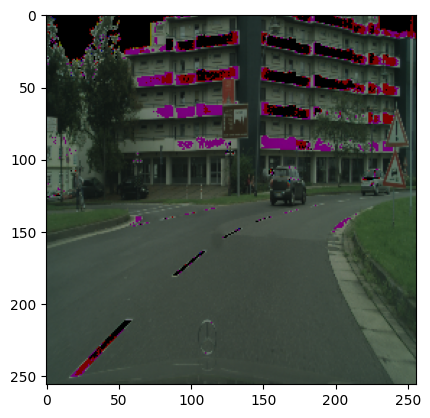

In [10]:
import matplotlib.pyplot as plt

for data in trainDataset:
    img = ((data[0][0] + 1) * 127.5).astype(np.int8)
    mask = data[1][0].astype(np.int8).reshape(256, 256, 1)

    print(img.shape)
    print(mask.shape)

    plt.imshow(img)
    break

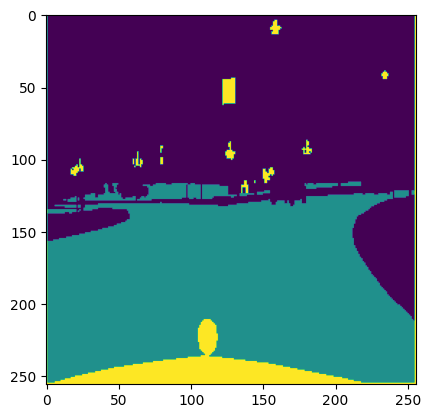

In [11]:
plt.imshow(mask)

In [6]:
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred):
    # True positive 1 & 1
    TP = np.bitwise_and(
        (y_true == 1), (y_pred == 1)).sum()
    # False positive 0 & 1
    FP = np.bitwise_and(
        (y_true == 0), (y_pred == 1)).sum()
    # True negative 0 & 0
    TN = np.bitwise_and(
        (y_true == 0), (y_pred == 0)).sum()
    # False negative 1 & 0
    FN = np.bitwise_and(
        (y_true == 1), (y_pred == 0)).sum()

    output = np.array([[TN, FP], [FN, TP]])

    return output, output.sum()

def run_confusion_matrix(y_pred, dataset, normalize=False):
    BATCH = IMG = 0
    MASK = 1

    matrix = np.array([[0, 0], [0, 0]])
    total = 0

    for i, data in enumerate(dataset):
        y_true = np.reshape(data[MASK][BATCH], (256, 256)).flatten()

        matrixPartial, totalPartial = confusion_matrix(y_true, y_pred[i].flatten())

        matrix += matrixPartial
        total += totalPartial

    if normalize:
        matrix = matrix / total
    
    return matrix.tolist()

def mIOU(y_true, y_pred):
    ulabels = np.unique(y_true)[:-1]

    iou = np.zeros(len(ulabels))

    for k, u in enumerate(ulabels):
        inter = (y_true == u) & (y_pred == u)
        union = (y_true == u) | (y_pred == u)

        iou[k] = inter.sum() / union.sum()

    return iou.mean()

def run_mIOU(y_pred, dataset):
    BATCH = IMG = 0
    MASK = 1
    
    mIOUList = []
    
    for i, data in enumerate(dataset):
        y_true = np.reshape(data[MASK][BATCH], (256, 256)) \
                .flatten()

        mIOUList.append(mIOU(y_true, y_pred[i].flatten()))
    return np.array(mIOUList).round(5).tolist()

class plot_distribution():

    def __init__(self, plot_name):
        self.plot_name = plot_name
        self.data = {}

    def add_plot(self, name, data):
        self.data[name] = data

    def show_plot(self, save=False):
        fig, ax = plt.subplots()
        ax.set_title(self.plot_name)
        
        sns.set_context("paper")
        
        ax.set_xlabel("mIOU")
        ax.set_ylabel("mIOU frequency")

        ax = sns.histplot(data=self.data, legend=True, kde=True, 
                          common_norm=False, stat="count", ax=ax,
                          palette=sns.color_palette(n_colors=5))

        if save:
            fig.savefig("plot/"+self.plot_name+".svg", format="svg")
        
        self.data = {}
        plt.show()

TEST FOLDS IN TESTSET

In [10]:
from utils import lossesAccuracyfuncs
from utils import model_utils
import models
imageSize = (256, 256)

modelTestResult = {}

for modelFolder in modelsFolder:
    mobileLayers = {"shallowLayer": "block_2_project_BN", "deepLayer": "block_12_project_BN"}
    alpha = float(modelFolder[modelFolder.find("alpha_")+6: modelFolder.find("alpha_")+9])
    modelName = modelFolder.replace("/", "\\").split("\\")[-1]
    modelTestResult[modelName] = {}
    n_classes = 2

    train_val_data = data_utils.load_datasetCV(train_val_X, train_val_Y, 
                                             IMAGE_SIZE=IMG_SIZE, BATCH_SIZE=1,
                                             REMAP="binary", N_FOLDS=3, SEED=42)

    for i, (trainDataset, valDataset, n_classes) in enumerate(train_val_data):
        model = models.deeplabV3(imageSize=imageSize, nClasses=n_classes, alpha=alpha, withArgmax=True, mobileLayers=mobileLayers)
        test_data = data_utils.load_testset(test_X, test_Y, IMAGE_SIZE=IMG_SIZE, BATCH_SIZE=1, REMAP="binary")

        y_pred = model.predict(valDataset, verbose=0).astype(np.uint8)

        model.load_weights(f"{modelFolder}\\fold_{i}.ckpt")

        modelTestResult[modelName][i] = {}
        modelTestResult[modelName][i]["results"] = run_mIOU(y_pred, valDataset)
        modelTestResult[modelName][i]["mean"] = np.mean(modelTestResult[modelName][i]["results"])
        modelTestResult[modelName][i]["std"] = np.std(modelTestResult[modelName][i]["results"])

import json

with open("testMetricsVal.json", "w") as f:
    json.dump(modelTestResult, f)

In [60]:
import pandas as pd
METRICS = {}
for modelFolder in modelsFolder:
    modelName = modelFolder.replace("/", "\\").split("\\")[-1]
    mean = 0

    for i in range(3):
        METRICS[modelName+f"_fold_{i}"] = {
            "mean": modelTestResult[modelName][i]["mean"],
            "std": modelTestResult[modelName][i]["std"]}
        mean += modelTestResult[modelName][i]["mean"]

    METRICS[modelName+"_all"] = {"mean": mean / 3}
df = pd.DataFrame.from_dict(METRICS, orient="index")
df.to_csv("testMetricsVal.csv")

In [ ]:
outlier_dict

In [ ]:
import json

newDict = {}
for key in mIOU_dict.keys():
    newDict[key] = []
    for dicts in mIOU_dict[key]:
        keys = list(dicts.keys())
        newDict[key].append({
            keys[0]:{
                keys[1]: dicts[keys[1]],
                keys[2]: dicts[keys[2]],
                keys[3]: dicts[keys[3]],
                "IoU" : dicts[keys[0]]}})
        
for key in newDict.keys():
    with open(key + '.json', 'w') as fout:
        json.dump({key:newDict[key]}, fout)

In [ ]:
from glob import glob

files = sorted(glob("*.json"))
files[:3]

In [ ]:
import json

i = 0

metricDict = {}

for file in files:
    with open(file, 'r') as fin:
        # read json with a model cross validation and 
        data = json.load(fin)

        split = list(data.keys())[0]
        
        auxDict = {}

        # remove list of IoU
        for key in data[split].keys():
            # del data[split][key]["mIOU_ValSet"]
            data[split][key]["name"] = key

            fold = "fold " + key.split("_")[1]

            auxDict[fold] = data[split][key]

        metricDict[split] = auxDict

len(metricDict)

In [ ]:
list(metricDict.keys())

In [ ]:
def getOutliers(tempList):
    if not isinstance(tempList, np.array.__class__):
        tempList = np.array(tempList)

    q1, q3 = np.quantile(tempList, [.25, .75])

    outlierLess = q1 - 1.5 * (q3-q1)
    outlierMore = q3 + 1.5 * (q3-q1)

    outlier_index = np.logical_or(tempList <= outlierLess, tempList >= outlierMore)

    outlierList = tempList[outlier_index]

    return outlierList, outlier_index

In [ ]:
from IPython.display import display
import pandas as pd

keys = list(metricDict.keys())

for key in keys:
    key = key.split("_")

    split = f"alpha_{key[1]}_layer_{key[3]}"

    plotOBJ = plot_distribution(split.replace("_", " "))

    dictAux = {}
    print(split)
    for fold in sorted(metricDict[split].keys()):
        mIOUValues = np.array(metricDict[split][fold]["mIOU_ValSet"])

        outlierList, outlier_index = getOutliers(mIOUValues)
        lenOutliers = len(outlierList)
        

        dictAux[fold] = {
            "Mean": np.mean(mIOUValues),
            "StandardDeviation": np.std(mIOUValues),
            "Outliers": lenOutliers}

        # mIOUValues = mIOUValues[~outlier_index]

        plotOBJ.add_plot(fold, mIOUValues)

    df = pd.DataFrame(dictAux).transpose()
    display(df)

    plotOBJ.show_plot(save=True)

In [ ]:
mIOUList = run_mIOU(model, valDataset)

In [ ]:
plot_distribution(mIOU_dict['alpha_0.5_layer_11'][0]['deeplabv3+_1_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip'])

In [ ]:
matrix = run_confusion_matrix(model, valDataset, normalize=True)
print(matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["False", "True"])
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='Groundtruth')
plt.show()

In [ ]:
matrix = run_confusion_matrix(model, test_data, normalize=False)
print(matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["False", "True"])
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='Groundtruth')
plt.show()